In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from pandas.errors import ParserWarning

warnings.simplefilter(action='ignore', category=ParserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import utils.data as datutils

In [72]:
mah_df_dict = {}
dir = 'data/gadgetx3k_20/AHFHaloHistory/'
for f in sorted(os.listdir(dir)):
    file = dir + f
    mm0 = datutils.get_mah(file)
    id = datutils.find_id(file)
    mah_df_dict[id] = mm0

In [73]:
dsdf = pd.read_csv(
    'data/gadgetx3k_20/G3X_progenitors/DS_G3X_snap_128_center-cluster_progenitors.txt',
    sep=r'\s+', header=0)

int_columns = [0, 1, 2, 7]
column_names = dsdf.columns

for idx in range(len(column_names)):
    col_name = column_names[idx]
    if idx in int_columns:
        dsdf[col_name] = dsdf[col_name].astype(int)
    else:
        dsdf[col_name] = dsdf[col_name].astype(float)
dsdf.drop(columns=['Hid[1]', 'DS_200[2]', 'DS_500[7]'], inplace=True)
dsdf.set_index('rID[0]', inplace=True)

In [79]:
zs = [x['Redshift'].to_list() for x in mah_df_dict.values()]
redshifts = []
for z in zs:
    redshifts.extend(z)

z_list = list(set(redshifts))
len(z_list)

159

In [115]:
lengths = [len(x['Redshift']) for x in mah_df_dict.values()]
most_indx = np.argmax(lengths)
max_size = lengths[most_indx]
corrs_list = []
filtered_z_list = []
# z_list = []
mah_ds_dict = {}

# for z in mah_df_dict[most_indx]['Redshift']:
for z in z_list:
    mah_df = pd.DataFrame(columns=['ID', 'M/M0'])
    
    for region in mah_df_dict.keys():
        row = mah_df_dict[region].loc[mah_df_dict[region]
                                      ['Redshift'] == z, ['M/M0']]
        row['ID'] = region
        if not row.empty:
            mah_df = pd.concat([mah_df, row], ignore_index=True)

    if len(mah_df) < 200:
        continue
          
    filtered_z_list.append(z)
    mah_df.set_index('ID', inplace=True)

    df = mah_df.reset_index().merge(
        dsdf.reset_index(),
        left_on='ID',
        right_on='rID[0]',
        how='inner'
    )

    df.set_index('ID', inplace=True)
    df.drop('rID[0]', axis=1, inplace=True)
    mah_ds_dict[z] = df
    corrs = df.corr(method='spearman')
    corrs_list.append(corrs)
    # z_list.append(z)


# Use the filtered list for calculations
z_array = np.array(filtered_z_list)
aexp = 1/(1+z_array)

In [116]:
eta_200 = [df.loc['eta_200[3]', 'M/M0'] for df in corrs_list]
delta_200 = [df.loc['delta_200[4]', 'M/M0'] for df in corrs_list]
fm_200 = [df.loc['fm_200[5]', 'M/M0'] for df in corrs_list]
fm2_200 = [df.loc['fm2_200[6]', 'M/M0'] for df in corrs_list]
eta_500 = [df.loc['eta_500[8]', 'M/M0'] for df in corrs_list]
delta_500 = [df.loc['delta_500[9]', 'M/M0'] for df in corrs_list]
fm_500 = [df.loc['fm_500[10]', 'M/M0'] for df in corrs_list]
fm2_500 = [df.loc['fm2_500[11]', 'M/M0'] for df in corrs_list]

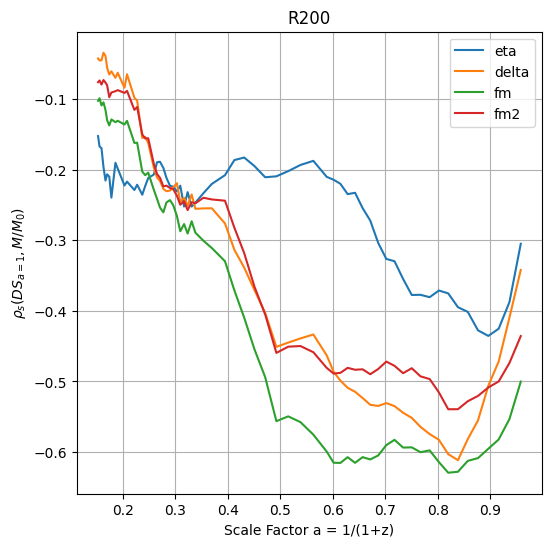

In [117]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.set_title('R200')
axs.plot(aexp, eta_200, label='eta')
axs.plot(aexp, delta_200, label='delta')
axs.plot(aexp, fm_200, label='fm')
axs.plot(aexp, fm2_200, label='fm2')
axs.set_xlabel('Scale Factor a = 1/(1+z)')
axs.set_ylabel(r'$\rho_s (DS_{a=1}, M/M_0)$')
axs.grid()
plt.legend()
plt.show()

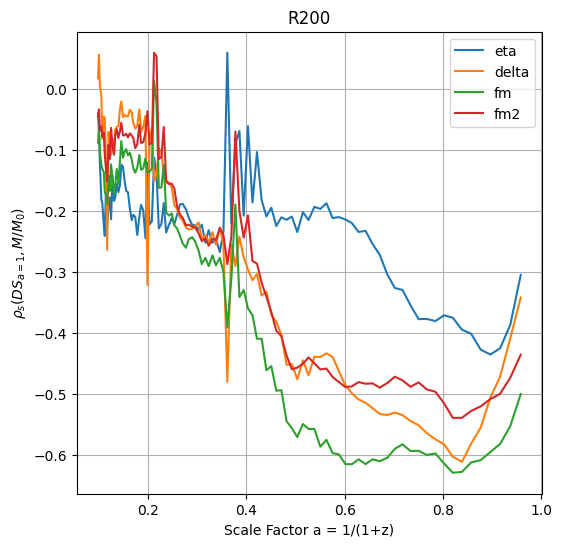

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.set_title('R200')
axs.plot(aexp, eta_200, label='eta')
axs.plot(aexp, delta_200, label='delta')
axs.plot(aexp, fm_200, label='fm')
axs.plot(aexp, fm2_200, label='fm2')
axs.set_xlabel('Scale Factor a = 1/(1+z)')
axs.set_ylabel(r'$\rho_s (DS_{a=1}, M/M_0)$')
axs.grid()
plt.legend()
plt.show()

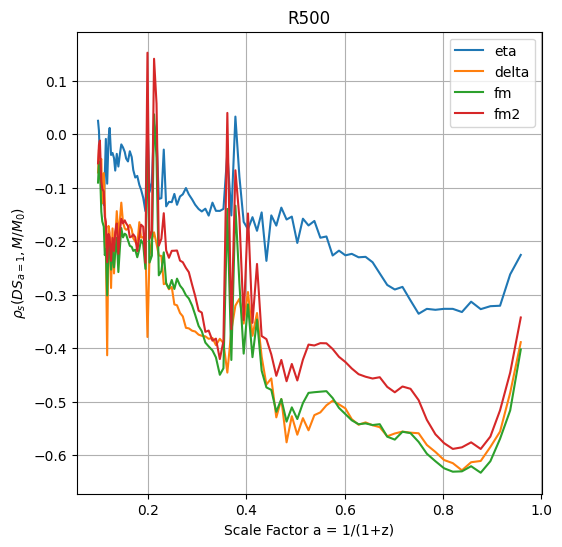

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.set_title('R500')
axs.plot(aexp, eta_500, label='eta')
axs.plot(aexp, delta_500, label='delta')
axs.plot(aexp, fm_500, label='fm')
axs.plot(aexp, fm2_500, label='fm2')
axs.set_xlabel('Scale Factor a = 1/(1+z)')
axs.set_ylabel(r'$\rho_s (DS_{a=1}, M/M_0)$')
axs.grid()
plt.legend()
plt.show()

In [ ]:
fm2_200_p10 = datutils.get_perc(mah_ds_dict, param='fm2_200[6]', q=10)
fm2_200_p25 = datutils.get_perc(mah_ds_dict, param='fm2_200[6]', q=25)
fm2_200_p50 = datutils.get_perc(mah_ds_dict, param='fm2_200[6]', q=50)
fm2_200_p75 = datutils.get_perc(mah_ds_dict, param='fm2_200[6]', q=75)
fm2_200_p90 = datutils.get_perc(mah_ds_dict, param='fm2_200[6]', q=90)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.set_title('fm2_200')
axs.plot(aexp, fm2_200_p50, color='b')
axs.fill_between(aexp, fm2_200_p10, fm2_200_p90, color='b', alpha=0.2)
axs.fill_between(aexp, fm2_200_p25, fm2_200_p75, color='b', alpha=0.3)
axs.set_xlabel('Scale Factor a = 1/(1+z)')
axs.set_ylabel(r'$\rho_s (DS_{a=1}, M/M_0)$')
axs.grid()
plt.show()

### Now for aexp(M/M0)...

In [5]:
size = 100  
mm0 = np.linspace(1e-5, 1, size)      # set up mah array
mm0_dict = {}
for m in mm0:
    # create dataframe for each mm0 value
    mm0_dict[m] = pd.DataFrame(columns=['aexp'])

In [6]:
tol = 1e-2
for mah in mah_df_list:
    # For each row in each mah snap, if it is close to an mm0 value then go to
    # dataframe at corresponding mm0_dict key and add the row(s) to that df.
    # In the end, for each mm0 value there is a df of aexp values.
    for m in mm0:
        err = np.abs((mah['M/M0'] - m))
        mask = err < tol
        mm0_dict[m] = pd.concat([mm0_dict[m], mah['aexp'][mask]])

In [7]:
# now we assemble the dictionary of ds+aexp params
# each key is an mm0 val, each val is the joint df
ds_aexp_dict = {}
for k, df in mm0_dict.items():
   if len(df) > len(dsdf):
      df1 = df.sample(len(dsdf))
      df2 = dsdf
   else:
      df1 = df
      df2 = dsdf.sample(len(dsdf))
   ds_aexp_dict[k] = pd.concat([df2.reset_index(drop=True),
                                df1.reset_index(drop=True)], axis=1)

In [ ]:
ds_aexp_corrs = {}
for k, v in ds_aexp_dict.items():
    ds_aexp_corrs[k] = v.corr(method='spearman')

In [ ]:
eta_200 = [df.loc['eta_200[3]', 'aexp'] for _, df in ds_aexp_corrs.items()]
delta_200 = [df.loc['delta_200[4]', 'aexp'] for _, df in ds_aexp_corrs.items()]
fm_200 = [df.loc['fm_200[5]', 'aexp'] for _, df in ds_aexp_corrs.items()]
fm2_200 = [df.loc['fm2_200[6]', 'aexp'] for _, df in ds_aexp_corrs.items()]
eta_500 = [df.loc['eta_500[8]', 'aexp'] for _, df in ds_aexp_corrs.items()]
delta_500 = [df.loc['delta_500[9]', 'aexp'] for _, df in ds_aexp_corrs.items()]
fm_500 = [df.loc['fm_500[10]', 'aexp'] for _, df in ds_aexp_corrs.items()]
fm2_500 = [df.loc['fm2_500[11]', 'aexp'] for _, df in ds_aexp_corrs.items()]

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
fig.suptitle('R200')

axs[0, 0].plot(mm0, eta_200, label='eta')
axs[0, 0].grid()
axs[0, 0].legend()

axs[0, 1].plot(mm0, delta_200, label='delta')
axs[0, 1].grid()
axs[0, 1].legend()

axs[1, 0].plot(mm0, fm_200, label='fm')
axs[1, 0].grid()
axs[1, 0].legend()

axs[1, 1].plot(mm0, fm2_200, label='fm2')
axs[1, 1].grid()
axs[1, 1].legend()

axs[1, 0].set_xlabel('M/M0')
axs[1, 1].set_xlabel('M/M0')
axs[0, 0].set_ylabel(r'$\rho_s (DS_{a=1},aexp)$')
axs[1, 0].set_ylabel(r'$\rho_s (DS_{a=1},aexp)$')

plt.tight_layout()
plt.legend()
plt.show()

### Gonna try this using Ismael's code

In [ ]:
# from multicam.mah import get_am

In [23]:
mah = mm0.sort_values('M/M0', ascending=True)
mah

,M/M0,Redshift,aexp
105,0.000008,9.165,0.098377
104,0.000009,8.977,0.100231
102,0.000012,8.521,0.105031
103,0.000016,8.792,0.102124
101,0.000020,8.345,0.107009
...,...,...,...
4,0.326835,0.092,0.915751
3,0.574417,0.068,0.936330
2,0.893229,0.044,0.957854
1,0.981598,0.021,0.979432


In [8]:
from scipy.interpolate import interp1d

In [9]:
def get_am(ma, scales, min_mass_bin, n_bins=100, log_spacing=True):
    """
    1. Inversion is only a well-defined process for monotonic functions, and m(a) for an
    individual halo isn't necessarily monotonic. To solve this, the standard redefinition of a(m0)
    is that it's the first a where m(a) > m0. (This is, for example, how Rockstar defines halfmass
    scales.)

    2. Next, first pick your favorite set of mass bins that you'll evaluate it at. I think
    logarithmic bins spanning 0.01m(a=1) to 1m(a=1) is pretty reasonable, but you should probably
    choose this based on the mass ranges which are the most informative.

    3. Now, for each halo with masses m(a_i), measure M_peak(a_i) = max_j{ m(a_j) | j <= i}.

    4. Remove (a_i, M_peak(a_i)) pairs where M_peak(a_i) = M_peak(a_{i-1}), since this will mess
    up the inversion.

    5. Use scipy.interpolate.interp1d to create a function, f(m), which evaluates a(m).
    For stability, you'll want to run the interpolation on log(a_i) and log(M(a_i)), not a_i and M
    (a_i).

    6. Evaluate f(m) at the mass bins you decided that you liked in step 2. Now you can run your
    pipeline on this, just like you did for m(a).
    """
    assert np.sum(
        np.isnan(ma)) == 0, "m(a) needs to be filled with `fill_value` previously."

    # 1. + 2.
    if log_spacing:
        mass_bins = np.linspace(np.log(min_mass_bin), np.log(1.0), n_bins)
    else:
        mass_bins = np.log(np.linspace(min_mass_bin, 1.0, n_bins))

    # 3.
    # NOTE: Make function monotonic. We assume start is early -> late ordering.
    # NOTE: ma should not have any cuts.
    # fmax ignores nan's (except beginning ones)
    m_peak = np.fmax.accumulate(ma, axis=1)
    
    # 4. + 5.
    fs = []
    for i in range(len(m_peak)):  # pylint: disable=consider-using-enumerate
        pairs = [(scales[0], m_peak[i][0])]
        count = 0

        for j in range(1, len(m_peak[i])):
            # keep only pairs that do NOT satisfy (a_{j-1}, Ma_{j-1}) = (a_j, Ma_j)
            if pairs[count][1] != m_peak[i][j]:
                pairs.append((scales[j], m_peak[i][j]))
                count += 1

        assert len(
            pairs) != 1, "Only 1 pair added, so max reached at a -> 0, impossible."

        _scales = np.array([pair[0] for pair in pairs])
        _m_peaks = np.array([pair[1] for pair in pairs])
        fs.append(
            interp1d(np.log(_m_peaks), np.log(_scales),
                     bounds_error=False, fill_value=np.nan)
        )

    # 6.
    am = np.array([np.exp(f(mass_bins)) for f in fs])
    return am, np.exp(mass_bins)

In [16]:
# 1. Define common aexp grid (e.g. 100 steps from a=0.05 to a=1.0)
common_aexp = np.linspace(0.15, 1.0, 80)

# 2. Build ma array (n_halos, n_timesteps)
mah = np.full((len(mah_df_list), len(common_aexp)),
             np.nan)  # fill with NaN for safety

for i, df in enumerate(mah_df_list):
    a = df['aexp'].values
    m = df['M/M0'].values

    # Make sure a and m are sorted by a
    sort_idx = np.argsort(a)
    a_sorted = a[sort_idx]
    m_sorted = m[sort_idx]

    # Only interpolate over increasing a
    interp_func = interp1d(
        a_sorted, m_sorted,
        bounds_error=False,
        fill_value=np.nan  # leave outside values as nan
    )

    mah[i] = interp_func(common_aexp)

# Now call get_am
am, mbins = get_am(ma=mah, scales=common_aexp, min_mass_bin=1e-5)

In [17]:
np.any(np.isnan(mah))

np.False_

NameError: name 'u' is not defined